<a href="https://colab.research.google.com/github/Loriane-07/PRA3024AnalysisofBigDatainPhysics/blob/main/Week2_GWDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment week 2 GWDA**

The program pycbc was downloaded in order to use the functions whithin the package to analyse GW data from the Livingston and Hanford detectors.

In [207]:
!pip install lalsuite pycbc

Necessary imports:

In [208]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

## **ASSIGNMENT 1**

### Part 1

Accessing the website from which the data will be downloaded.

In [209]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



**Loading the event**

In this first part of the assignment, the event that will be analyzed is the following one: GW170817. The time window investigated will be from 224 seconds before the merging occured until 32 seconds after the merging. The data from two detectors, Livingston (L1) and Hanford (H1), will be used. This is to ensure that the signal detected is a gravitational wave and not another phenomenon that would have occured close to one of the detector.

In [210]:
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
  ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                  "{}:LOSC-STRAIN".format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)

In [211]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants thsqat are currently available
print(fd_approximants())

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4HM_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'SpinTaylorT4Fourier', 'SpinTaylorT5Fourier', 'NRSur4d2s', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'PreTaylorF2', 'multiband', 'TaylorF2_INTERP', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSpin_INTERP', 'SEO

**Data preparation**

First, the time window (256s here) containing the event was loaded. Then, the highpass filter was used to remove the low frequencies (below 15Hz in this case) from the dataset. The dataset was also resampled to 2048Hz. Two seconds at the end and at the beginning of the dataset were removed in order to ensure continuity. In fact, since only a part of the whole event is downloaded, the beginning and the end of the dataset might be abruptly cut. Finally, a frequency domain version of the data was computed.

The two graphs display the data from both detectors as indicated by the titles of the graphs.

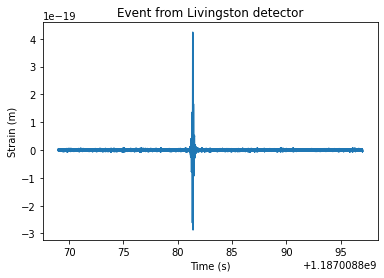

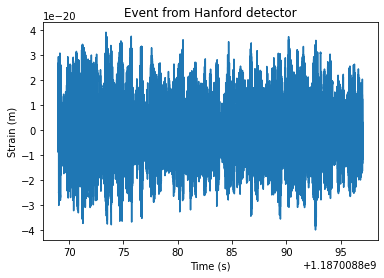

In [212]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

for ifo in ['L1', 'H1']:
    # Loading 256 seconds which include event time
    ts = merger.strain(ifo)
    # Remove low frequencies, downsample data to 2048Hz
    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
    # Crop dataset
    strain[ifo] = strain[ifo].crop(2, 2)
    # Frequency domain 
    stilde[ifo] = strain[ifo].to_frequencyseries()

pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.title('Event from Livingston detector')
pylab.show()

pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.title('Event from Hanford detector')
pylab.show()

#help(highpass)

### Part 2

**Spectrum power density.**

As the frequencies below 15Hz were removed in the previous step, the graph displays frequencies ranging from 20 to 1024 Hz. It can be observed on the graph that the Livingston detector has a higher sensitivity especially at low frequencies.

*Note: both the y and the x-axis are at the logarithmic scales.*

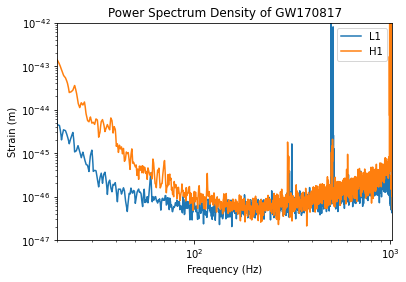

In [213]:
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:
    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
    pylab.xlabel('Frequency (Hz)')
    pylab.ylabel('Strain (m)')
    pylab.title('Power Spectrum Density of GW170817')
    pylab.legend()

**Signal to Noise Ratio (SNR) plot**

First, the mass of the system must be estimated. In order to do so, the plot will comprise masses ranging from 1.2 to 1.6 solar masses (range given by the tutor). The SNR will be calculated every 0.03 solar masses. For simplicity, it was assumed that both masses were equal, and the spin components were not taken into account.

Then for each mass in the interval 1.2 to 1.6, a template waveform was generated. The starting frequency of the waveform (f_lower) was set to 25 Hz. The resulting vector was then resized before generating the template. Finally, four seconds were removed to account for the template and PSD filter both at the beginning and at the end of the template. In addition, four sceonds were removed at the beginning to compensate for the length of the template.

The methodology above was performed first on the H1 dataset and then on the L1 dataset. This allowed to plot the Signal to noise ratio versus the total mass of the system.

*Note: the matched_filter function returns a complex form of the signal to noise ratio. Therefore , the absolute value of the SNR is taken in order to have a plot with only the real part of the SNR.*

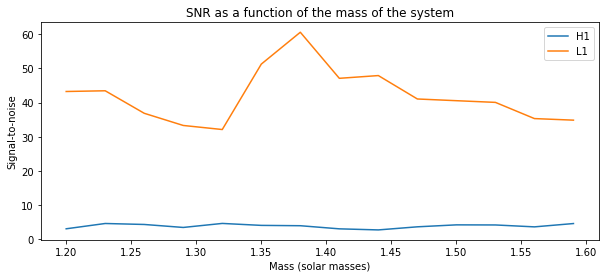

In [214]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
import pylab
from pycbc.waveform import get_td_waveform

mass1 = numpy.arange(1.2, 1.6, 0.03 ) #mass range bewteen 1.2 to 1.6 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate waveform
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=25)

    # Resizing the vector to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=25.0)

    # Remove time (as explained in the above text box)
    snr_H1 = snr.crop(4 + 4, 4)

    #Absolute value to have the real part of the SNR
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=25.0)

    # Resize the vector to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=25.0)

    # Remove time
    snr_H1 = snr.crop(4 + 4, 4)

    #Absolute value to have the real part of the SNR
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.title ('SNR as a function of the mass of the system')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass (solar masses)')
pylab.legend()
pylab.show()

**Mass of the system**

Combining, both the data from the H1 and L1 detector, it is found that the mass of the system is 1.38 solar masses under the assumption that m1 = m2.

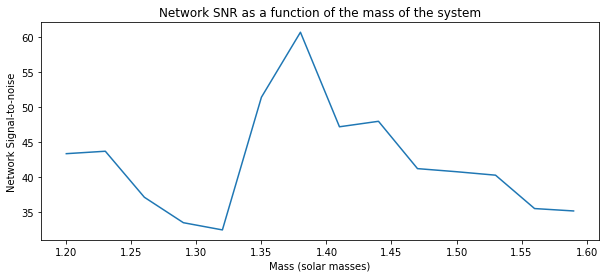

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


In [215]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.title('Network SNR as a function of the mass of the system')
pylab.xlabel('Mass (solar masses)')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])



As the mass of the system was found in the previous section, it is now possible to calculate the SNR for this specific mass (1.38 Solar masses). Otherwise, it would be required to calculate the time series for each mass. Again, it is assumed that both masses are equal for simplicity.

After resizing the vector to match the data, the data is shifted such that the merger location is located (approximatively) at the first chunck of data. This is done with the function `cyclic_time_shift`. This function rotates the data, such that it matches the merger location. The merger location is known from the waveform generation as `get_td_waveform` returns a waveform with the merger at the starting time.

As can be seen in the graph displayed below, the signal is not well represented and there must be an error in the processing of the signal.




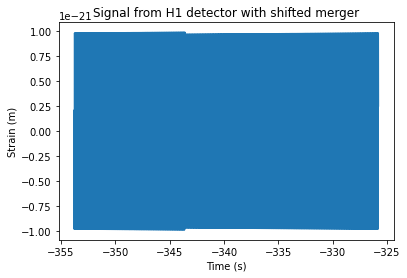

In [216]:
m = 1.38 # Solar masses
conditioned = strain['H1']
bp, bc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# Resize the vector to match data
bp.resize(len(conditioned))
 
# shift the merger 
template = bp.cyclic_time_shift(bp.start_time)

pylab.plot(bp.sample_times, template)
pylab.title('Signal from H1 detector with shifted merger')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.show()

**SNR**

The signal to noise ratio is found by matching a template to the data. After calculating the match, the data is cropped. This is done because the filtering might lead to discrepancies at the beginning and at the end of the template as it might be cut abruptly. In this case, 4 seconds at the beginning and the end of the snr are removed to account for this phenomenon. In addition, the template length is reduced by 4 seconds at the beginning of the event.

The `matched_filter` function used below returns a complex SNR. Hence, when plotting the data, the absolute value of the SNR is taken so the real part of the signal is returned.

The plot shows that the SNR is above 8 which indicates that a signal is present in the sample analyzed.

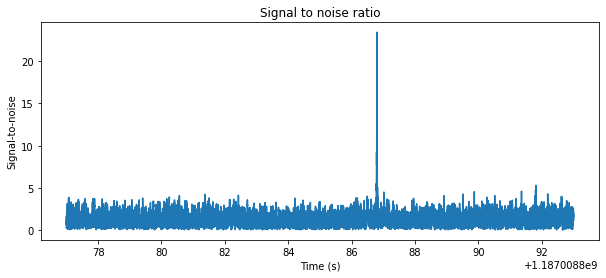

We found a signal at 1187008886.7954102s with SNR 23.442173873221382


In [217]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo], low_frequency_cutoff=20.0)

#Cropping the dataset
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.title('Signal to noise ratio')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

**Plotting the template against the event**

The template is aligned with the data by tuning the following parameters: the time, the amplitude and the phase of the signal to noise ratio peak. Then, both the data and the template are whitened. The highpass and lowpass filters are applied in order to remove the frequencies below 30 Hz and above 300 Hz respectively.

Unfortunately, the plot does not display the expected behaviour. In fact, the template is zero-wired. Attempts to correct that were made by trying to tuned the above-mentioned parameters but it did not make the template any closer to the actual data.

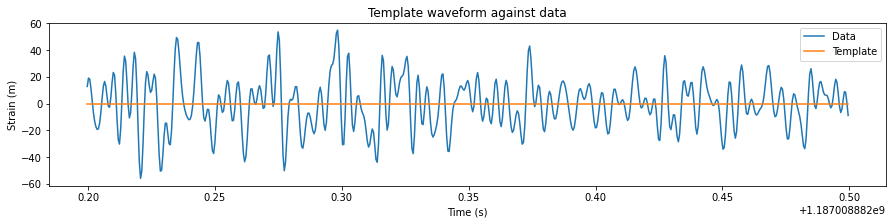

In [218]:
from pycbc.filter import sigma

# Shift template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# Scale template to that have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.title('Template waveform against data')
pylab.legend()
pylab.show()

By plotting the template waveform, it is posssible to see that the reason why it does not match the data is because they are not at the same scale. In fact, while on the above graph it can be observed that the strain of the event analyzed is in order of magnitude of -60 to 60, the template is in the order of magnitude of 10^(-6) as displyed by the graph below. I was not able to find out how to change the scale of the tempalte.

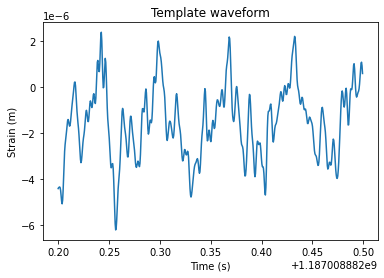

In [219]:
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.title('Template waveform')
pylab.show()

### Part 3

**Generating a waveform**

In this section, a gravitational wave signal for equal masses binary masses is generated. The mass is set to 10 solar masses. The frequencies below 30 Hz are removed from the sample. The approximation used in this case is 'TaylorF2'.

The plot displays the waveform generated. 

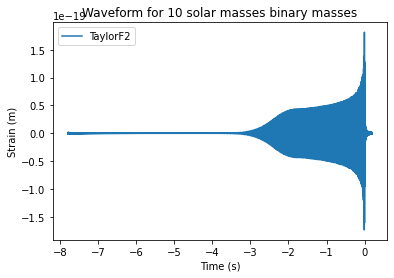

In [220]:
import pylab
from pycbc.waveform import get_td_waveform

for apx in ['TaylorF2']:
    sp, sc = get_td_waveform(approximant=apx,
                                 mass1=10,
                                 mass2=10,
                                 delta_t=1.0/4096,
                                 f_lower=30)

    pylab.plot(sp.sample_times, sp, label=apx)

pylab.ylabel('Strain (m)')
pylab.xlabel('Time (s)')
pylab.title('Waveform for 10 solar masses binary masses')
pylab.legend()
pylab.show()

**Waveform generation for mass range**

First, all the parameters are set. The range of masses to be investigated was chosen to be comprised between 5 and 15.1 solar masses. Waveforms were generated for every mass in this range by steps of 0.1 solar masses (again m1 = m2). 

The same waveform as described above was generated as well as another set of waveforms determined by the range of masses. The aim of this section was to compare each waveform in the mass range with the waveform generated for a specified mass. It was expected that by plotting the match against the mass of the system, a peak would be observed for 10 solar masses.

The waveforms were all resized to the same length before the match was calculated. 

The graph shows the waveforms generated by the range given with tha approximant TaylorF2.

[0.06711431685631124, 0.06878077119785428, 0.07056460425044213, 0.07229218875218364, 0.07415481177518775, 0.07614483818116098, 0.07831580693420458, 0.08017602251609882, 0.08232373243523726, 0.0845691432944931, 0.08685457431920823, 0.0890847808242727, 0.09137881064839533, 0.09379292024836894, 0.0961509329550756, 0.09881062122674178, 0.10130750807003026, 0.10394817439056452, 0.10690643296911849, 0.10997666262080344, 0.1131631771172771, 0.1162376690563754, 0.11977418552305534, 0.12325153162473582, 0.12700251555654513, 0.13078719312565276, 0.13491747900290038, 0.1394674490003194, 0.14411185743108462, 0.14849651099600644, 0.15450884179729146, 0.159899210569149, 0.16578859780966285, 0.17256821821568613, 0.17985255523182864, 0.18610407830538048, 0.19619654232351963, 0.2046035793241213, 0.21654253914533747, 0.22777392174815111, 0.24077909851878887, 0.25909530547989806, 0.27766887408995217, 0.29375812131603624, 0.32536634936525016, 0.3673683213995058, 0.40996112131721074, 0.4945634105852096, 0.

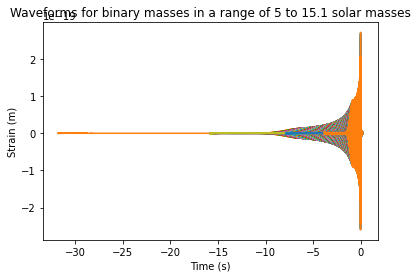

In [221]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

#hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
f_low = 30
mass1 = numpy.arange(5, 15.1, 0.1 ) 
mass2 = mass1
Snr_list1 = []
snrs1 = {}

for apx in ['TaylorF2']:
  #Generating a waveform with m = 10 solar masses
  sp, sc = get_td_waveform(approximant=apx,
                                 mass1=10,
                                 mass2=10,
                                 delta_t=1.0/4096,
                                 f_lower=30)

  pylab.plot(sp.sample_times, sp, label=apx)

  #Generating waveform with mass ranae
  for i in range(len(mass1)):
    #Generate a waveform with mass range
    ma = mass1[i] # noted ma as m is already used for the match value
    xp, xc = get_td_waveform(approximant=apx,
                                 mass1=ma,
                                 mass2=ma,
                                 delta_t=1.0/4096,
                                 f_lower=30)

    pylab.plot(xp.sample_times, xp, label=apx)

    # Resize the waveforms to the same length
    tlen = max ( len (sp), len (xp))
    sp . resize(tlen)
    xp . resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_fr = 1.0 / sp . duration
    flen = tlen // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_fr, f_low)
    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, i = match(xp, sp, psd = psd, low_frequency_cutoff = f_low)
    #print(i)

    Snr_list1.append(m)
  snrs1[i] = Snr_list1
print(Snr_list1)

pylab.ylabel('Strain (m)')
pylab.xlabel('Time (s)')
pylab.title('Waveforms for binary masses in a range of 5 to 15.1 solar masses')
pylab.show()

**Waveform range**

In the code below, waveforms in the range of 5 to 15 solar masses are generated. Frequencies inferior to 30 Hz are removed from the data set. As can be seen in the plot, there is a peak at 10 solar masses. This shows that the code written gave the expected outcome.

In [238]:
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs1[i], 'bo')
pylab.xlim(xmin=5, xmax=15)
pylab.title('Matching waveforms')
pylab.xlabel('mass')
pylab.ylabel('match')
pylab.show()

KeyError: ignored

<Figure size 720x288 with 0 Axes>

## ASSIGNMENT 2

### Part 1

**Loading the data**

The data was loaded from the link provided in the assignment sheet. Then, it was transformed into a time serie.

In [223]:
from pycbc.psd import welch, interpolate
import pycbc.types 
import numpy as np

d = np.load('noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d
#help(pycbc.types.TimeSeries(d[:; 1]))
#help(pycbc.types.frequencyseries)
print(data)
print(d)
print(delta_t)
print(len(data))

[-5.16209393e-20 -6.56159222e-20 -8.82291920e-20 ...  7.25991474e-20
  6.00433087e-20  3.42870480e-20]
[-5.16209393e-20 -6.56159222e-20 -8.82291920e-20 ...  7.25991474e-20
  6.00433087e-20  3.42870480e-20]
0.00048828125
4096000


Estimation of the power spectrum density (PSD) with the Welch method from PyCBC.

In [224]:
from pycbc.psd import welch, interpolate

psds1 = interpolate(welch(d), 1.0 / d.duration)
print(psds1)
print(psds1.delta_f)

[5.18453252e-45 5.19649601e-45 5.20845951e-45 ... 1.51580302e-47
 1.51290833e-47 1.51001364e-47]
0.001


**Matched filtering**

Waveforms in a range of 5 to 15.1 solar masses were generated in steps of 0.1 of accuracy. Frequencies below 30 Hz were removed from the waveform and the two masses were assumed to be equal. The generated waveforms were resized before the match was calculated. The match value was calculated between the frequency series made out of the data and the generated waveforms. As previously mentioned in Assignment 1, part 1, SNR section, 8 seconds of data were removed at the beginning and 4 seconds were removed at the end of the sample.

The plot below shows that the Signal to noise ratio has a value that is inferior to 8 which means that there is no signal in the sample investigated.

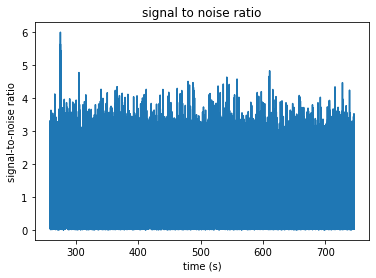

Maximum SNR 5.998196927467564


In [225]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab

mass1 = numpy.arange(5, 15.1,0.10 ) 
mass2 = mass1

flow = 30 #Hz
stilde = data.to_frequencyseries()

for i in range(len(mass1)):
  ma = mass1[i]
  dp, dc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                        mass1=ma, 
                                        mass2=ma,
                                        f_lower=30, 
                                        delta_f=stilde.delta_f)

dp.resize(len(stilde))  
snr_m = pycbc.filter.matched_filter(dp, stilde, psd=psds1,
                                      low_frequency_cutoff=flow)


# Remove regions corrupted by filter wraparound
snr_m = snr_m[len(snr_m) // 4: len(snr_m) * 3 // 4]
#Crop dataset
snr_m = snr_m.crop(4 + 4, 4)

pylab.plot(snr_m.sample_times, abs(snr_m))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.title ("signal to noise ratio")
pylab.show()
print ( 'Maximum SNR', max(abs(snr_m)) )

### Part 2

**Whitening the data**

The data is whitened by dividing the frequency series by the power spectrum density. This ratio is then converted to timeseries and this is referred to as white data. Whitened data assumes a gaussian distribution as can be seen in the histogram below.

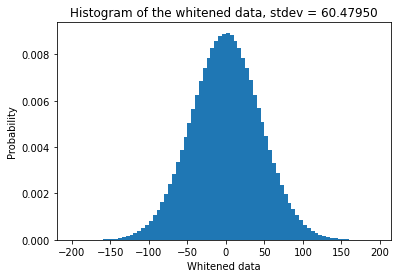

In [226]:
# We do it this way so that we can whiten both the template and the data
import pycbc.psd
import matplotlib.pyplot as plt
import statistics

white_data = (data.to_frequencyseries() / psds1** 0.5 ).to_timeseries()

bins = range(-200, 200,5)
sig = statistics.stdev(white_data)

pylab.hist(white_data, bins, density=True)
pylab.xlabel("Whitened data")
pylab.ylabel("Probability")
pylab.title("Histogram of the whitened data, stdev = %.5f" %(sig))
pylab.show()



### Part 3

**Take an arbitrary waveform**

The waveform was generated as explained previously. Here, the mass was set at 3 solar masses and an additional parameter, the distance (in Mpc) was included for the waveform generation.

The plot shows the generated waveform with the approximant TaylorF2. 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


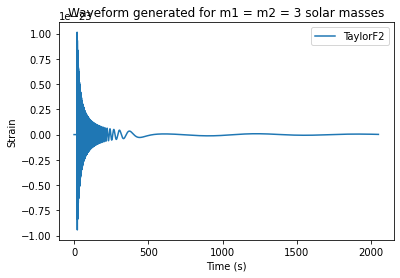

0.000244140625
[0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j ... 2.07607267e-26-4.28512072e-26j
 2.07244631e-26-4.28657445e-26j 2.06881906e-26-4.28802509e-26j]


In [239]:
import pylab
from pycbc.waveform import get_td_waveform

#Generate a frequency waveform domain
tp, tc = get_fd_waveform(approximant='TaylorF2',
                         mass1=3,
                         mass2=3,
                         delta_f = 1.0/10.0,
                         distance = 500,
                         f_lower = 20, f_final = 2048)

pylab.plot(tp.sample_frequencies, tp, label=apx)
pylab.title('Waveform generated for m1 = m2 = 3 solar masses')
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')

pylab.legend()
pylab.show()

print(tp.delta_t)
print(tp)


In [228]:
#help(welch)
#help(pycbc.types.TimeSeries)

**Optimal SNR**

The aim of this section is to demonstarte that the gaussian approximation made while whitening the data is not representative of the noise that is recorded in gravitational wave signals.

The data in the file 'noise_ts_4096Hz.npy' was divided into a 1000 samples (sample_len). Then, the psd was estimated for each sample with the welch method provided by pycbc. This allowed to compute the psd of the data sample (data_chunck), referred to as psd_chunk in the code below. Finally, the SNR was found by using the function given in the assignment sheet. The SNR values were saved in an array.

In [229]:
from pycbc.filter import sigmasq
from pycbc.psd import interpolate, welch

sample_nb = 1000
sample_len = int(len(data)/sample_nb)
print(sample_len)

opt_snr = []
for i in range(0, sample_nb):
  #Creating the data samples
  data_chunck = data[i*sample_len :(i+1)*sample_len]
  # PSD data samples
  psd_chunck = interpolate(welch(data_chunck), tp.delta_f)
  # Saving the snr 
  SNR = (pycbc.filter.sigmasq(tp, psd_chunck))**0.5
  opt_snr.append(SNR)

print(opt_snr)

4096
[13.900072164742735, 14.25980480176253, 15.39725185910863, 16.695652511415073, 25.384662055289937, 22.121055533163428, 17.857995836018972, 15.645502383349744, 15.188884188974232, 14.765843519145172, 17.369187871031365, 16.170216138772233, 15.44980272882395, 15.090183999012503, 20.238433185370866, 19.56460412508892, 15.857799624569926, 17.35640913729302, 15.945813221402862, 18.746221623901413, 17.268290543055866, 18.94146841597881, 18.80293173483563, 15.472465578576246, 16.238345364831158, 20.071139143634632, 14.432171313338872, 22.483420377178483, 16.268642876398324, 16.854429420660853, 14.4309971317068, 20.07649927004071, 15.542179654298431, 19.173932822494752, 16.893555208503283, 15.217261037172298, 17.351285778362577, 14.850111627729937, 15.677609131699379, 18.651728596590242, 27.509448215766223, 16.116812304888384, 15.247914584382459, 15.151631840657949, 17.47813976617177, 16.169602097724834, 15.139424138968673, 17.830717068378036, 17.835014022411304, 18.431021307127658, 18.05

**SNR without approximation**

Below is the histogram made out of the noise file without whitening the data. As hypothesized, the noise does not follow a gaussian shape in the recorded data by the detectors.

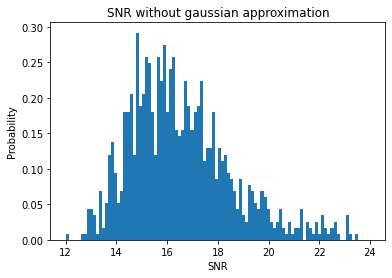

In [230]:

pylab.hist(opt_snr , range =(12, 24), bins= 100, density=True)
pylab.xlabel("SNR")
pylab.ylabel("Probability")
pylab.title("SNR without gaussian approximation")
pylab.show()


## Assignment 3

### Part 1

**aLIGO PSD**

The power spectrum density of the aLIGO detector is plotted in order to be able to find its horizon plot.

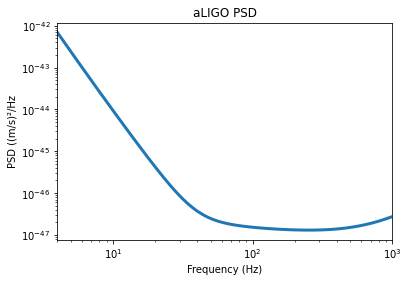

In [231]:
import pycbc.psd
import numpy as np

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/delta_f) + 1
psd_ligo = aLIGOZeroDetHighPower(flen, delta_f, flow)

psd_ligo.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_ligo.data[-1] = np.inf

pylab.loglog(psd_ligo.sample_frequencies, psd_ligo, linewidth=3)
pylab.title('aLIGO PSD')
pylab.xlim(xmin=flow, xmax=1000)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD ((m/s)²/Hz')
pylab.show()


In [232]:
#help(pycbc.waveform.waveform.print_fd_approximants())

**Horizon plot**

In the code below, waveforms were generated in a range of 5 to 500 solar masses. This range was chosen as this is the TaylorF2 approximation only works for this range of masses. Other approximant were used (IMRPhenomD, SEOBNRv4 and EOBNRv2_ROM) but they made the program crashed or the error: "internal function call failed: input domain error" arised.

As usual, the waveforms were resized to the size of the psd of the aLIGO detector. Then , the SNR for each waveform was estimated. The SNR above 8 were saved in a list. Then the horizon distance was calculated by dividing 1 by the estimated SNR saved.

In [233]:
from pycbc.filter import sigmasq

mass1 = numpy.arange(5, 500, 1) 
mass2 = mass1

snr_dist = []
dist_list = []
dist_d = {}

#Genereate waveform
for i in range(len(mass1)):
  ma = mass1[i]
  zp, zc = get_fd_waveform(approximant='TaylorF2',
                            mass1=ma,
                            mass2=ma,
                            delta_f = 1/16,
                            distance = 1000,
                            f_lower=20.0, f_final = 2048.0) 
  
  # Resize vector to match data
  zp.resize(len(psd_ligo))

  #Estimaate the SNR
  SNR = (np.sum((4*zp*np.conj(zp)*zp.delta_f/psd_ligo).data).real)**0.5
  # Finding SNR above 8
  if SNR >= 8:
    snr_dist.append(int(SNR))
    
for a in range(len(snr_dist)):
  #Finding distance
  dist = 1/snr_dist[a] # in Mpc
  dist_list.append(dist)

dist_d[i] = dist_list
print(dist_d)

{494: [0.1, 0.09090909090909091, 0.07692307692307693, 0.06666666666666667, 0.0625, 0.05555555555555555, 0.05263157894736842, 0.047619047619047616, 0.045454545454545456, 0.041666666666666664, 0.04, 0.038461538461538464, 0.03571428571428571, 0.034482758620689655, 0.03333333333333333, 0.03125, 0.030303030303030304, 0.029411764705882353, 0.027777777777777776, 0.02702702702702703, 0.02631578947368421, 0.025, 0.024390243902439025, 0.023809523809523808, 0.022727272727272728, 0.022222222222222223, 0.021739130434782608, 0.02127659574468085, 0.02040816326530612, 0.02, 0.0196078431372549, 0.019230769230769232, 0.018867924528301886, 0.01818181818181818, 0.017857142857142856, 0.017543859649122806, 0.017241379310344827, 0.01694915254237288, 0.01639344262295082, 0.016129032258064516, 0.015873015873015872, 0.015625, 0.015384615384615385, 0.014925373134328358, 0.014705882352941176, 0.014492753623188406, 0.014285714285714285, 0.014084507042253521, 0.013888888888888888, 0.0136986301369863, 0.013333333333

**Horizon plot**

The plot below represents the horizon distance for the aLIGO detector as a function of the mass range. The horizon plot does not have the expected shape. I did not manage to determine what part of the code was wrong.

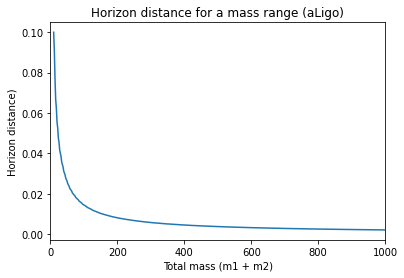

In [234]:
tot_mass = mass1 + mass2
pylab.plot(tot_mass, dist_d[a])
pylab.title('Horizon distance for a mass range (aLigo)')
pylab.xlabel('Total mass (m1 + m2)')
pylab.xlim(xmin = 0, xmax = 1000)
pylab.ylabel('Horizon distance)')
pylab.show()


### Part 2

**Commenting on part 1**

The horizon distance represents the upper limit of the area in which the detector is able to detect signal. This means that the trendline on the plot represents the limit at which the aLIGO detector would be able to provide events for which the signal can be distinguished from the noise as a function of the total mass of the system. Above that limit, even if there is a gravitational wave signal emitted by an event, the detector does not have the sensitivity required in order to differentiate it from the noise.

The above graph shows that the higher the mass of the system the smaller the horizon distance. This means that for massive systems, gravitational wave signals can be detected by the aLIGO detector from distnaces "close" to us. For smaller masses, signals can be detected in a wider range. This might be due to the fact that massive systems would produce gravitational waves with a bigger amplitude and/or a lower frequency. In fact, a lower frequency would provoke the wavelength to be longer and hence the arms of the detector might not be long enough in order to detect the gravitational waves produced by massive systems. 

In the lecture (Singha, 2021), it is stated that the amplitude of the gravitational wave depends on the masses (m1 and m2) of the system. Hence, it could be hypothesized that massive systems produce signals with an higher amplitude or too low amplitude than the detector can measure.

**Commenting graph assignment**

As the graph I managed to produce is not the same as the one I should have had, in this section I will comment on the graph presented in the hint sheet.

The graph in the assignments shows that the horizon distance of the aLIGO detector is highest for systems having a mass around 500 solar masses. The further distance that can be reach by the aLIGO detector is 16 Gpc. For systems which have a mass higher than 1500 solar masess, the horizon distance is already reduced by half (8Gpc). Hence, one can conclude that the aLIGO detector is efficient in detecting events for medium mass systems that occur relatively close to us. 

### Part 3

**Einstein telescope PSD**

The graph below shows the psd of the Einstein telescope.

0.0625


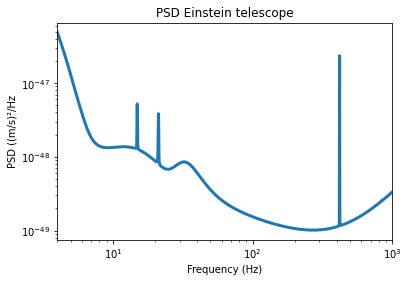

In [235]:
import pycbc.psd
import numpy as np

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_e = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
psd_e.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_e.data[-1] = np.inf

print(psd_e.delta_f)

pylab.loglog(psd_e.sample_frequencies, psd_e, linewidth=3)
pylab.title('PSD Einstein telescope')
pylab.xlim(xmin=flow, xmax=1000)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD ((m/s)²/Hz')
pylab.show()

**Horizon plot**

The horizon plot was made in the same way as explained for the aLIGO horizon plot. Except that here, the psd of the Einstain telescope was used.

In [236]:
from pycbc.filter import sigmasq

mass1 = numpy.arange(5, 500, 10) 
mass2 = mass1

snr_dist = []
dist_list = []
dist_d = {}

#Genereate waveform
for i in range(len(mass1)):
  ma = mass1[i]
  zp, zc = get_fd_waveform(approximant='TaylorF2',
                            mass1=ma,
                            mass2=ma,
                            delta_f = 1/16,
                            distance = 1000,
                            f_lower=20.0, f_final = 2048.0) 
  
  # Resize vector to match data
  zp.resize(len(psd_e))
  #Estimate the SNR
  SNR = (np.sum((4*zp*np.conj(zp)*zp.delta_f/psd_e).data).real)**0.5
  # Finding SNR above 8
  if SNR >= 8:
    snr_dist.append(int(SNR))
    
for a in range(len(snr_dist)):
  #Finding distance
  dist = 1/snr_dist[a] # in Mpc
  dist_list.append(dist)


dist_d[i] = dist_list
#print(snr_dist)

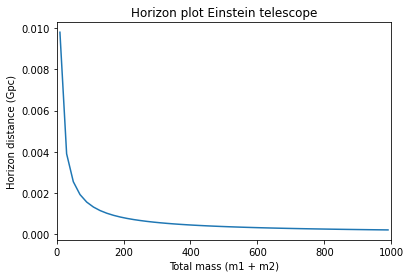

In [237]:
tot_mass = mass1 + mass2
pylab.plot(tot_mass, dist_d[i])
pylab.title('Horizon plot Einstein telescope')
pylab.xlabel('Total mass (m1 + m2)')
pylab.xlim(xmin = 0, xmax = 1000)
pylab.ylabel('Horizon distance (Gpc)')
pylab.show()

**Comparing the two detectors**

If the Einstein telescope and the aLIGO detector are compared, it can be said that the Einstein telescope can detect signals at about one tenth of the horizon distance of the aLIGO detector. However, the shape of the graph seems to indicate that both detectors work better for smaller masses than for larger ones.

**Comparing graphs from the assignment**

In this section both the graphs that should have been obtained will be compared.

From those, it can be said that the Einstein telescope is able to detect signal up to horizon distance about 50 times larger than the aLIGO detector (if the peaks are compared). This is in contradiction with the graphs produced in this assignment. In addition, while the aLIGO detector is more snesitive for masses in the 500 solar masses range, the Einstein telescope peaks for masses around 2000 solar masses. Another feature that can be noticed is that the Einstein telescope displays a (approximatively) symmetric bell curve-like shape. This means that it does not seem to be better at recording events from lower mass system than to highly massive system. On the other hand, the aLIGO detector sharply increases for systems ranging from 0 to 500 solar masses. Before decreasing slowly in an exponential like manner. 

In conclusion, if a gravitational wave is emitted by a source further away than 16 Gpc, the aLIGO detector will most likely not be able to detect the signal. On the other hand, at larger distances and for massive mass systems, the Einstein telecope will be able to detect gravitational wave signals. 

## Reference

Singha A. (2021). Gravitational waves data analysis, Maastricht University. Retrieved from https://canvas.maastrichtuniversity.nl/courses/5826/files/530754?module_item_id=112521

Singha A. (2021). GWDA, Github. Retrieved from https://github.com/Ayatri/GWDA/blob/main/GravitationalWaveEventAnalysis.ipynb.

The PYCBC website was also used (https://pycbc.org/pycbc/latest/html/index.html) as well as Stack Overflow.